<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Experiments and Hypothesis Testing

_Authors: Alexander Egorenkov (DC)_

---

<a id="learning-objectives"></a>
### Learning Objectives
After this lesson, you will be able to...

- Explain the distinction between causation and correlation.
- Use directed acyclic graphs to represent causal hypotheses.
- Identify what missing data is and how to handle it.
- Test a hypothesis using a sample case study.

# Hypothesis Testing and Data Science

"Data scientist" is an overly broad term. Here is one useful distinction that may be emerging:

- **Data scientists** build models and deploy solutions to the product itself.
- **Product scientists** (often called "data scientists" as well) use applied stats to support A/B testing and continuous product improvement.

We will follow common usage by using "data scientist" for people who work in either kind of roles, but the work they do is pretty different. For instance, **Hypothesis testing** is central for product scientists but may not matter at all to the other kind of data scientist.

## Load and Inspect Advertising Data
---

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# This allows plots to appear directly in the notebook.
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# Read data into a DataFrame.
# We use index_col to tell Pandas that the first column in the data has row labels.
data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)

In [3]:
# Inspect first five rows of the data
# /scrub/
data.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


#### Questions About the Advertising Data

Let's pretend you work for the company that manufactures and markets this new device. The company might ask you the following: "On the basis of this data, how should we spend our advertising money in the future?"

<a id="what-are-the-featurescovariatespredictors"></a>
### What are the Features/Covariates/Predictors?

- **TV:** Advertising dollars spent on TV for a single product in a given market (in thousands of dollars).    
- **Radio:** Advertising dollars spent on radio.
- **Newspaper:** Advertising dollars spent on newspaper.

<a id="what-is-the-outcomeresponse"></a>
### What Is the Outcome/Response?

Sales of a single product in a given market (in thousands of widgets).

<a id="what-do-you-think-each-row-in-the-dataset-represents"></a>
### What Does Each Row in the Data Set Represent?

A market where the ads have been shown.

<a id="math-review"></a>
## Math Review
---

<a id="covariance"></a>
### Covariance

Covariance is a measure of the joint variability between two random variables.

**Sample covariance:**

$$cov(X, Y) = \frac {\sum_i{(x_i - \bar{X})(y_i - \bar{Y})}} {n-1}$$

**Exercise.**

- Consider a data set like our advertising data that is organized with one row for each observation and one column for each variable. You could calculate the covariance for two variables in this data set by doing a separate calculation on each row and then averaging the results. What calculation would you do along each row? Do it for this example, assuming that the average for TV is 80 and the average for newspaper is 40.

| TV | Newspaper |
|------|-------|
| 50 | 65 |

/scrub/

$(50 - 80) \times (65 - 40) = -30 \times 25 = 750$

- When is this calculation positive, and when is it negative? How does this fact help you interpret covariance values?

/scrub/

It is positive when both variables are above their mean values or both variables are below their mean values. Variables with positive covariance tend to be either both above or both below their mean values for a given individual, while those with negative covariance tend to go in opposite directions for a given individual.

- What is the sample covariance of a variable $X$ with itself?

/scrub/

The sample variance of $X$: $$cov(X, X) = \frac {\sum_i{(x_i - \bar{X})(x_i - \bar{X})}} {n-1}$$

<a id="correlation"></a>
### Correlation

Correlation standardizes covariance by dividing by the standard deviations of the component variables. The result is a number between -1 and 1.

**(Pearson) Correlation Coefficient:**

$$corr(X,Y) = \frac {cov(X,Y)} {\sigma_X\sigma_Y}$$

![](../assets/images/correlation_examples.png)

<a id="the-variance-covariance-matrix"></a>
### The Variance-Covariance Matrix

The variance-covariance matrix shows the covariance between every variable in our data set:

$$\left[ \begin{array}{c}
var(X_1) & cov(X_1,X_2) & ... & cov(X_1,X_n)  \\
cov(X_2,X_1) & var(X_2) & ... & cov(X_2,X_n)  \\
... & ... & ... & ... \\
cov(X_n,X_1) & cov(X_n,X_2) & ... & var(X_n)
\end{array} \right]$$

#### Calculate the correlation matrix using the DataFrame's built-in `.cov()` method

In [4]:
# /scrub/
data.cov()

,TV,radio,newspaper,sales
TV,7370.949893,69.862492,105.919452,350.390195
radio,69.862492,220.427743,114.496979,44.635688
newspaper,105.919452,114.496979,474.308326,25.941392
sales,350.390195,44.635688,25.941392,27.221853


#### Calculate the correlation matrix using the DataFrame's built-in `.corr()` method:

In [5]:
# /scrub/
data.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


When we have a large amount of data, the correlation matrix may be too difficult to read. It can help to make a plot.

#### Use Seaborn's `.heatmap()` function to make a plot of the correlation matrix.

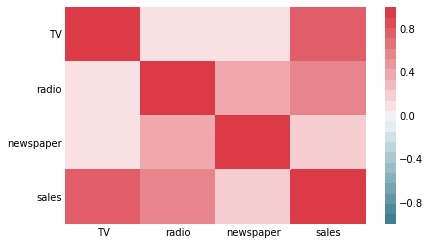

In [6]:
# /scrub/
fig, ax = plt.subplots()
sns.heatmap(data.corr(),
            vmin=-1, vmax=1, # Make the scale span -1 to 1
            cmap=sns.diverging_palette(220, 10, n=21), # Use a diverging blue-red scale with 21 levels
            ax=ax,
);

Of course, looking at linear association doesn't show us the whole picture. We can get a more detailed look with a scatterplot matrix.

#### Use Seaborn's `.pairplot()` function to make joint scatterplots of the data.

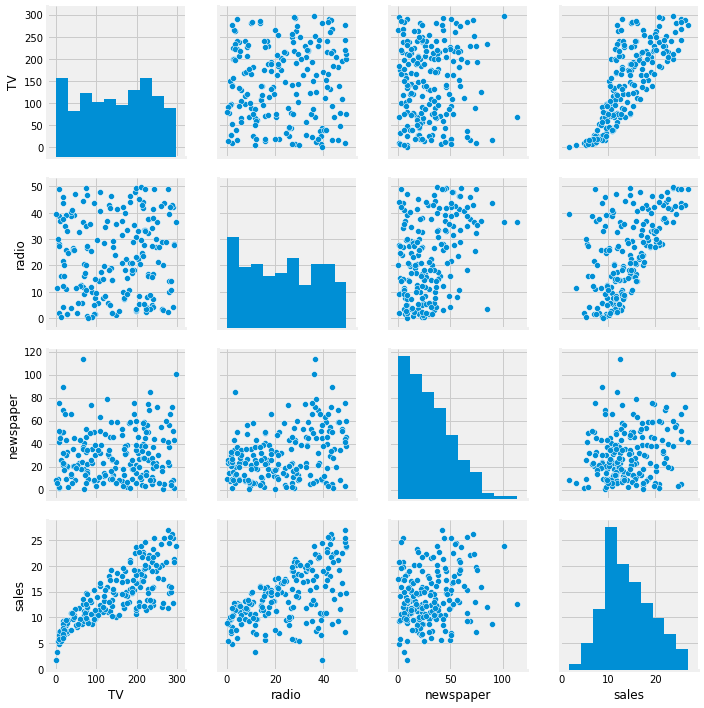

In [7]:
# /scrub/
sns.pairplot(data); # pairplot doesn't let us pass in an Axes

<a id="causation-and-correlation"></a>
## Causation and Correlation
---

**Objective**: Explain the difference between causation and correlation.

<a id="why-do-we-care"></a>
### Why Do We Care?

- **Observation:** Asthma is *negatively correlated* with complications for patients diagnosed with pneumonia.
- **Explanation 1:** Asthma has a protective effect for people with pneumonia.
- **Explanation 2:** Patients with asthma who come into the ER with pneumonia are treated more aggresively than those without asthma.

If Explanation 1 is correct, then you might be more inclined to send a pneumonia patient home if he or she has asthma.

If Explanation 2 is correct, then that approach would kill people.

### What is the difference between causation and correlation?

"$X$ is **correlated** with $Y$" means that *knowing* the value of $X$ can help you *infer* the value of $Y$ (using a linear model) when you don't interfere with the system.

"$X$ **causes** $Y$" means that you can wiggle $Y$ by wiggling $X$.

Correlation is about **information**. Causation is about **control**.

<a id="how-do-we-determine-if-something-is-causal"></a>
### How Do We Determine whether $X$ causes $Y$?

- **Best:** Perform an experiment in which you randomly vary $X$ and observe $Y$.
- **Alternative approach 1:** Consider some heuristics such as the following:
    - Strength of association
    - Consistency
    - Specificity
    - Temporality
    - Biological gradient
    - Mechanistic plausibility
    - Coherence
    - Analogy
- **Alternative approach 2:** Use causal search algorithms.

**Strength (effect size)**: A small association does not mean that there is not a causal effect, although the larger the association, the more likely the effect is to be causal.

**Consistency (reproducibility)**: Consistent findings observed by different persons in different places with different samples strengthens the likelihood of an effect.

**Specificity**: Causation is likely if there is a very specific population at a specific site and a disease with no other likely explanation. The more specific an association between a factor and an effect, the greater the probability of a causal relationship.

**Temporality**: The effect has to occur after the cause (and, if there is an expected delay between the cause and expected effect, then the effect must occur after that delay).

**Biological gradient**: Greater exposure should generally lead to greater incidence of the effect. However, in some cases, the mere presence of the factor can trigger the effect. In other cases, an inverse proportion is observed: greater exposure leads to lower incidence.

**Plausibility**: A plausible mechanism between cause and effect is helpful (but Hill noted that knowledge of the mechanism is limited by current knowledge).

**Coherence**: Coherence between epidemiological and laboratory findings increases the likelihood of an effect. However, Hill noted that "... lack of such [laboratory] evidence cannot nullify the epidemiological effect on associations."

**Analogy**: The effect of similar factors may be considered.

### What Causal Structures Can Give Rise to a Correlation Between $X$ and $Y$?

- $X$ causes $Y$.
- $Y$ causes $X$.
- Some third factor causes both $X$ and $Y$.
- $X$ and $Y$ both cause some third factor, and we sample that factor unevenly.

<a id="its-possible-that-x-causes-y"></a>
### X causes Y.
![](../assets/images/x-cause-y.png)

The diagram above is called a DAG (directed acyclic graph) -- a set of nodes and edges (arrows) without cycles. DAGs are useful for representing networks of dependencies, including causal dependencies.

An arrow from $X$ to $Y$ in a causal GAP indicates that $X$ is a cause of $Y$ and that there are no intermediate variables in our data set. (There are almost always intermediate variables that you *could* consider.)

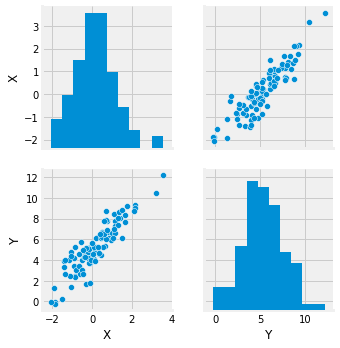

In [8]:
# Example where Y is a function of X:
X = np.random.randn(100)
Y = 5 + 2*X + np.random.randn(100)
dag = pd.DataFrame({'X':X, 'Y':Y})

# Make a pairplot of the data -- remember that pairplot() takes in a DataFrame!
sns.pairplot(dag)

<a id="y-causes-x"></a>
### Y causes X.
![](../assets/images/y-cause-x.png)

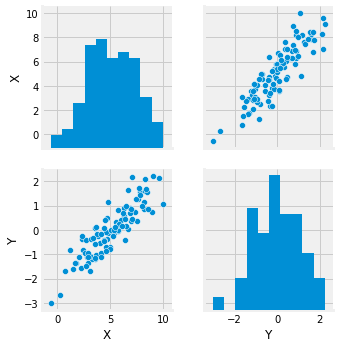

In [9]:
# Example where X is a function of Y:
Y = np.random.randn(100)
X = 5 + 2*Y + np.random.randn(100)
dag = pd.DataFrame({'X':X, 'Y':Y})

sns.pairplot(dag)

<a id="there-is-a-third-common-factor-that-causes-both-x-and-y"></a>
### There is a third common factor that causes both X and Y.
![](../assets/images/z-cause-xy.png)

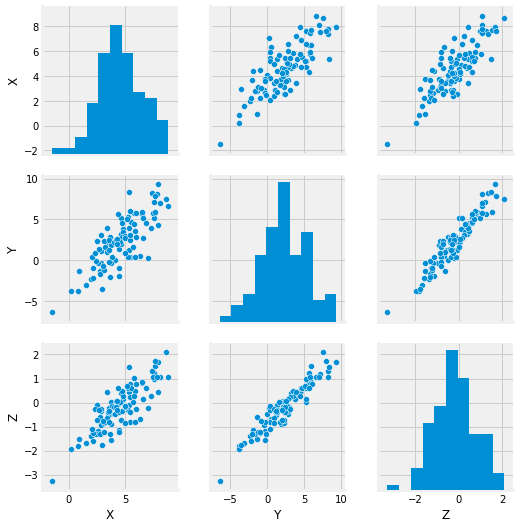

In [10]:
# Both X and Y are functions of Z:
Z = np.random.randn(100)

X = 5 + 2*Z + np.random.randn(100)
Y = 3 + 3*Z + np.random.randn(100)

common_cause = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})

sns.pairplot(common_cause)

<a id="both-x-and-y-cause-a-third-variable-and-the-dataset-does-not-represent-that-third-variable-evenly"></a>
### X and Y cause a third factor, but our data collect the third factor unevenly.

![](../assets/images/xy-causez.png)

This is tricky -- $X$ and $Y$ are probabilistically independent unconditionally, but dependent conditional on $Z$.

Consider this example:

- $Z$: Your throat is sore.
- $X$: You have strep throat.
- $Y$: You have bronchitis.

Let's say that having strep throat and having bronchitis are probabilistically independent -- they are separate diseases caussed by separate infectious agents that neither promote nor interfere with one another and they do not have any common causes. Nevertheless, when you go to the doctor's office with a sore throat and get a negative result on a strep test, you are likely to be sent home with a diagnosis of bronchitis.

**Moral:** Common effects induce *conditional dependence* among their causes.

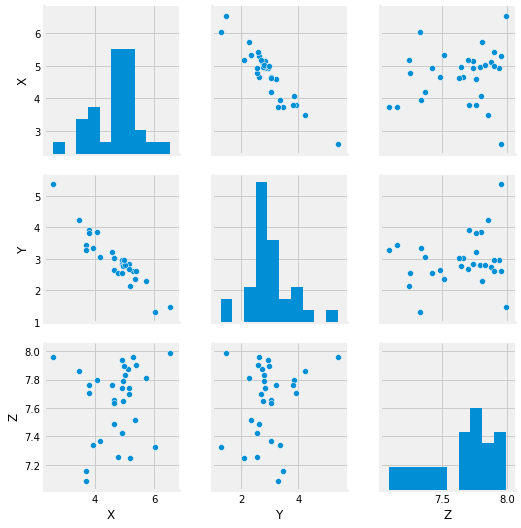

In [11]:
# Z is a function of X and Y:
X = 5 + np.random.randn(100)
Y = 3 + np.random.randn(100)
Z = X + Y + 0.1*np.random.randn(100)

common_effect = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})

sns.pairplot(common_effect[(7 < common_effect['Z']) & (common_effect['Z'] < 8)])

**Upshot:** A correlation is consistent with several causal hypotheses, which is why people say **you can't infer causation from correlation**.

### What Is a "Confounder"?

Suppose that people who carry cigarette lighters are 2.4 times more likely to contract lung cancer than people who don’t carry lighters.

Does this mean that the lighters are causing cancer?

As we've noted before, if lighters and cancer are both caused by smoking, there will be a correlation between lighters and cancer. This isn't the only possible diagram, but it makes the most sense.

![](../assets/images/smoke-lighter-cancer.png)

If we believe the structure above, conditioning on smoking by only looking at non-smokers removes the correlation between lighters and cancer. Smoking is a **confounder** of the causal relationship between having a lighter and contracting lung cancer.

In general, a **confounder** for the hypothesis that X causes Y is a variable that makes X correlated with Y by a path that doesn't run from X to Y.

Inferring causation from correlation is valid only when there is **no confounding** (e.g. due to uncontrolled common causes or selection bias for common effects) and the direction of causation is correct.

**Exercise.**

- Below, we filled in how to make a scatterplot for the columns `sales` vs `TV`. Using this as an example, make scatterplots for `sales` vs `radio` and `sales` vs `newspaper`.

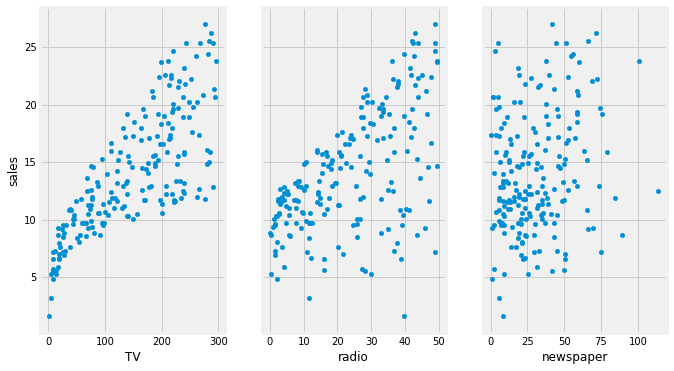

In [12]:
# Visualize the relationship between the features and the response using scatterplots:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True)

data.plot(kind='scatter', x='TV', y='sales', ax=ax0, figsize=(10, 6));
# /scrub/
data.plot(kind='scatter', x='radio', y='sales', ax=ax1);
data.plot(kind='scatter', x='newspaper', y='sales', ax=ax2);

- Is there a relationship between ads and sales? Which type of ads?

/scrub/

There appears to be a relationship. The relationship appears strongest between TV and sales.

- Can we say that ads of this type *cause* sales? Why or why not?

/scrub/

No. We haven't done an experiment, and we don't have supplementary information to support our heuristics. There's some plausibility to the idea that sales cause job ads (companies advertise in markets where they have a foothold), and market size at least seems like an obvious common cause.

- Would knowing how much money was spent on TV ads in a given market help you predict sales for that market? Why or why not?

/scrub/

Yes, because correlation is sufficient for predictive purposes.

- Can we say that increasing spending on TV ads in a particular market would be a good strategy for increasing sales in that market?

/scrub/

Not necessarily -- e.g. it's possible that the company just spends more on TV ads in big markets, where sales would be greater anyway, and that the TV ads have no effect.

### Section Summary

1. **Multiple causal structures that have different implications for action can give rise to the same patterns of correlation**.
1. **The best evidence about causation comes from randomized experiments**.
1. In the absence of randomized experiments, **distinguishing betwen causation and correlation requires subject-matter expertise.**

<a id="sampling-bias"></a>
## Sampling Bias
---

<img src="../assets/images/airplane_holes.png" width=300 align=left>

The red circles show locations of bullet holes that have been found on planes returning from combat missions. Where should they add armor?

<img src="../assets/images/amazon_ratings.png" width=300 align=left>

Online ratings for many products have a U-shaped distribution. Is it true that you either love these products or hate them?

<a id="forms-of-sampling-bias"></a>
### Types of Sampling Bias

- **Pre-screening:** Deliberately restricting the sample to a specific group or region.
- **Self-selection:** When someone has the ability to non-randomly decide what is included in a sample.
- **Survivorship bias:** When we select only surviving subjects in a sample over time.

<a id="problems-from-sampling-bias"></a>
### Problems That Arise From Sampling Bias
- We could overestimate or underestimate means and sample statistics for simple characteristics.
- It's possible to have artificial correlation where there should be none.

<a id="recovering-from-sampling-bias"></a>
### Recovering From Sampling Bias
- Prevent it when possible.
- Learn about the data-generating process and think about possible sources of sampling bias.
- Model the sampling process and correct for it.

<a id="missing-data"></a>
## Missing Data
---

Typical real-world data sets have missing data.

**Options for a  missing data point:**
    - Drop the observation.
    - Drop the variable.
    - Impute a value for that specific variable and observation.

**So, how do we decide?**

<a id="types-of-missing-data"></a>
### Types of Missing Data

- **Missing completely at random (MCAR)**
    - The reason that the data are missing is completely random and introduces no sampling bias.
    - In this case, it's safe to drop or impute.
    - We can test for this by looking at other attributes for missing and non-missing groups to see if they match.

- **Missing at random (MAR)**
    - The data are missing in a way that is related to another factor.
    - This is a form of sampling bias.
    - Like other instances of sampling bias, we can fix this by modeling the selection process.
        - This is done by building a model to impute the missing value based on other variables.

- **Missing not at random (MNAR)**
    - The response is missing in a way that relates to its own value.
    - We can't test for this.
    - We also can't fix this in a reasonable way.

<a id="class-imbalance"></a>
## Class Imbalance

Suppose we build a model to predict whether or not a person is carrying a weapon based on X-ray scans, and we find that it is 99% accurate on new data that we didn't use in training. Get, right?

Well, suppose that the test data set has 990 images with no weapon and 10 images with a weapon. **Why should learning this fact dampen our enthusiasm about our model?**

/scrub/

You could get 99% accuracy just by saying "no weapon" every time. You don't need a model for that. That's probably exactly what our model is doing, which means that it's failing in the cases that are most important to get right.

### Solutions to Class Imbalance

- **Undersample** the majority class.
- **Oversample** the minority class.
- Train and evaluate your model using metrics that reflect that relative importances of different types of errors.

<a id="introduction-to-hypothesis-testing"></a>
## Introduction to Hypothesis Testing
---

**Objective**: Test a hypothesis within a sample case study.

Before we get to causation vs. association, we need to establish an association.

### Hypothesis Testing Steps

- **Observation:** Smokers have better measured fitness on average than non-smokers in your sample.
- **Assumptions:** Samples were randomly drawn, measure of fitness is appropriate, you did all the math correctly.
- **Possible explanations:**
    - Smokers have better average fitness than non-smokers in the population.
    - You got a weird sample by chance.

Hypothesis testing is designed for this kind of case

1. Choose a **null hypothesis** which says that there is no association between smoking and fitness (or no positive relationship) and an **alternative hypothesis** which says that there is a relationship (or a positive relationship) between smoking and fitness.
2. Choose a **test statistic** that you will use to decide whether or not to reject the null hypothesis  -- e.g. the difference in average measured fitness between smokers and non-smokers.
3. Decide the probability $\alpha$ (conventionally $.05$) of rejecting the null hypothesis if it is true you are willing to accept, and calculate the **critical range** of values for the test statistic that gives you the best chance of rejecting it if it is false with no more than $\alpha$ probability of rejecting it if it is true.
4. Collect data and calculate the value of the test statistic. If it is in the critical range, **reject** the null hypothesis and accept the alternative. Otherwise, **fail to reject** the null.

**Warning:** The hypothesis test is valid only if the hypotheses and test statistic *were formulated without reference to the data*. (Likewise for p-values and confidence intervals, below.)

<a id="validate-your-findings"></a>
### P-Values

Here's another (equivalent) way to carry out a hypothesis test: reject the null hypothesis "at the $\alpha$ level" if and only if you get a **p-value** less than $\alpha$, where a p-value is the probability under the null hypothesis of a result at least as extreme as what you observe in the direction of the alternative hypothesis.

![](../assets/images/p_value.png)

A p-value is NONE of these things:

- Probability given the data that the null hypothesis is true/false.
- Probability given the data that the alternative hypothesis is true/false.
- Probability of the data.
- Probability of the data under the null hypothesis.
- Porbability of the data under the alternative hypothesis.
- Probability that the result is due to chance.

It is the probability under the null hypothesis of either the data or data that is more extreme in favor of the alternative hypothesis against the null hypothesis.

A conventional null hypothesis significance tests rejects the null hypothesis if this value is sufficiently small (typically less than .05).

/poll "Which of the following can we conclude given a p-value of .04? (Select all that apply.)" "We can reject the null hypothesis at the .05 level." "The probability that the null hypothesis is true is .04." "The probability that the null hypothesis is false is .04." "The probability that the alternative hypothesis is true is .04." "The probability that the alternative hypothesis is false is .04." "The probability of the observed data under the null hypothesis is .04." "The probability that the result is due to chance is .04."

/scrub/

Only a is correct.

<a id="confidence-intervals"></a>
### Confidence Intervals

Suppose we wanted to give an estimated range for the difference in fitness level between smokers and non-smokers. A **95% confidence interval** is an estimated range produced by a method that has the following property: if we were to apply if over and over again with varying data (i.e. different samples of smokers and non-smokers), it would contain the true value we are trying to estimate with a frequency that converges to 95% in the long run (if all of our assumptions are correct).

<a id="error-types"></a>
### Error Types

![](../assets/images/pregnant.jpg)

What is one case where a Type I error is worse than a Type II error?

What is one case where a Type II error is worse than a Type I error?

Image credit: https://effectsizefaq.com/2010/05/31/i-always-get-confused-about-type-i-and-ii-errors-can-you-show-me-something-to-help-me-remember-the-difference/

/scrub/

A Type I error is generally considered worse than a Type II error in criminal justice: we would rather let a guilty person go free than send an innocent person to prison.

A Type II error is generally considered worse than a Type I error in detecting cancer: false positives are bad (they cause stress and possibly unnecessary difficult treatments), but false negatives can be fatal.

## Case Study: A/B Testing Hypothesis Tests
---

### Scenario

You are a data science team working for a web-based company and you are planning to roll out a new website design. One of two competing designs were presented to random samples of users, and their ultimate purchase total was recorded (if any).

Your task is to determine which of the two designs yields higher total purchases and if the result is statistically significant.

In [13]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

%matplotlib inline
np.random.seed(42)

In [14]:
# Generate some data and randomize.

# Some people bought nothing, the others bought 
# with some distribution.
data1 = [0] * 50
data1.extend(np.random.normal(14, 4, 150))
np.random.shuffle(data1)

# The second design hooked less people, 
# but those that were hooked bought more stuff.
data2 = [0] * 100
data2.extend(np.random.normal(20, 5, 100))
np.random.shuffle(data2)

# Make a DataFrame.
df = pd.DataFrame()
df.loc[:, "A"] = data1
df.loc[:, "B"] = data2

df.head()

,A,B
0,14.685473,25.666710
1,20.152146,0.000000
2,14.274252,18.370134
3,12.122102,26.632519
4,18.228489,25.862179


#### Plot out the distributions of group A and group B.

- Plot a histogram of ONLY the group A column, and ONLY the group B column.

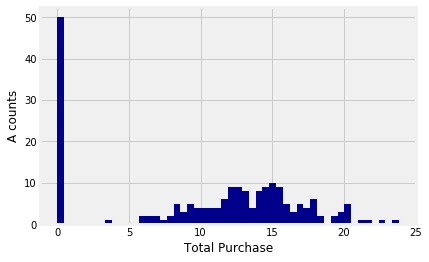

In [15]:
# Let's plot the data first.
# /scrub/
fig, ax = plt.subplots()
df.loc[:, 'A'].hist(bins=50, color=['darkblue'], ax=ax)
ax.set_ylabel("A counts")
ax.set_xlabel("Total Purchase");

**Exercise.**

- Make the same plot for data set "B."

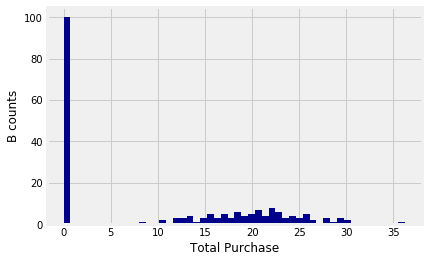

In [16]:
# /scrub/
fig, ax = plt.subplots()
df.loc[:, 'B'].hist(bins=50, color=['darkblue'], ax=ax)
ax.set_ylabel("B counts")
ax.set_xlabel("Total Purchase");

- Make a box plot of the two groups using Seaborn.

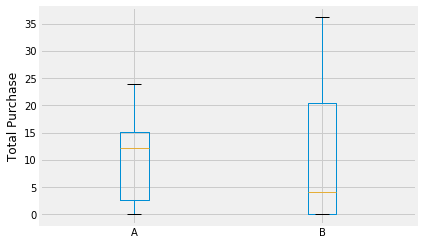

In [17]:
# /scrub/

fig, ax = plt.subplots()
df.plot.box(ax=ax)
ax.set_ylabel("Total Purchase");

---

#### Are our data sets (approximately) normal? Visualize the distributions and eyeball them to decide.

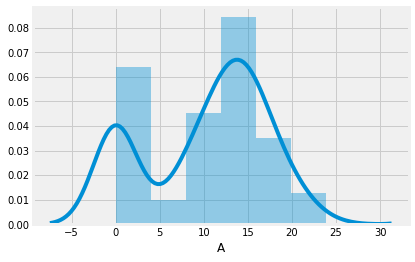

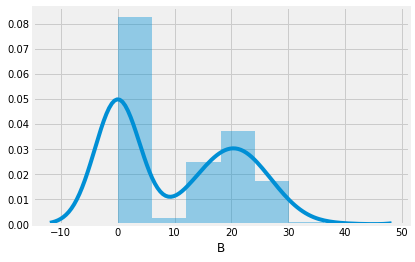

In [18]:
# /scrub/
fig, ax = plt.subplots()
sns.distplot(df["A"], ax=ax)
plt.show()

fig, ax = plt.subplots()
sns.distplot(df["B"], ax=ax)
plt.show()

/scrub/

They are not normal because of the spikes at zero. The distribution of purchase amount for people who do buy looks like it may be normal.

<a id="statistical-tests"></a>
### Statistical Tests

There are a few good statistical tests for A/B testing. Each one makes various assumptions.

- Student's t-test assumes the residuals are normally distributed and data have equal variances.
- Welch t-test assumes normal distributions but not necessarily equal variances.
- The Mann-Whitney test does not assume normality, which makes it more robust but less efficient for data that normally distributed. Rule of thumb requires at least 20 data points.

#### Which test is most appropriate for our data?

In [19]:
df.describe()

,A,B
count,200.000000,200.000000
mean,10.253019,10.173009
std,6.771692,10.829033
min,0.000000,0.000000
25%,2.640765,0.000000
50%,12.129592,4.151009
75%,15.192501,20.422830
max,23.852968,36.269926


In [20]:
df.var()

A     45.855814
B    117.267961
dtype: float64

In [21]:
print(df.shape)

(200, 2)


#### Use the Mann-Whitney test on our data.

- Look up the function [in SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html).
- Look up the test [on Wikipedia](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test).

In [22]:
u, p = stats.mannwhitneyu(df["A"], df["B"])

print(u)
print(p)

19740.0
0.40880656458636355


<a id="interpret-your-results"></a>
### Interpret Your Results
* Is there a significant difference in the mean total purchases in the two designs?
* Which design do you recommend? Why? 

/scrub/

The difference between total purchases is not significant.

In terms of total purchases, there is no recommendation to be made, but we can think about whether we prefer a larger number of customers or fewer customers who spend more money.

Ideally, we could learn from these designs and make a third design that attracts both the high- and low-volume purchasers.

# Projects

Due Mon. 5/14:

- [Unit 2 Project](https://git.generalassemb.ly/chi-ds-8/unit2_project)
- [Final Project Pt 1](https://git.generalassemb.ly/chi-ds-8/final_project/blob/master/requirements.md#proposal)

See [Final Project Tips](https://git.generalassemb.ly/chi-ds-8/final_project#tips)

# Questions?

# [Exit Tickets](https://docs.google.com/forms/d/e/1FAIpQLSfvZxGW3CHmZzIhNqz-5uzMeDTQHHDOH8G2ovTPbT5U6Q8KLA/viewform?usp=send_form)